In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Sat Jan 20 16:54:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.dalle_encoder import Encoder
from model.prior.randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.dalle_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [8]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -8
hp.const_sigma = True
hp.quantize = True

In [9]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 17.792236328125
encoder.encoder 17.792236328125
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 9.735363006591797
decoder.decoder 9.735363006591797
done


### Load

In [12]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-9/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0
-rw-rw-r-- 1 scpark scpark 0  1월 20 16:55 events.out.tfevents.1705737318.GPUSVR11


### Dataset

In [13]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print('done')

done


In [14]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [15]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [16]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

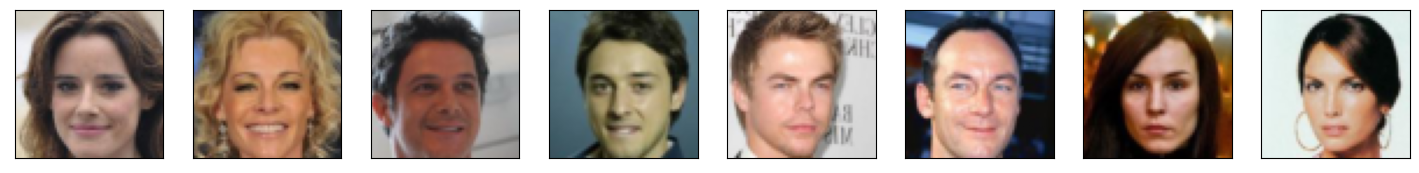

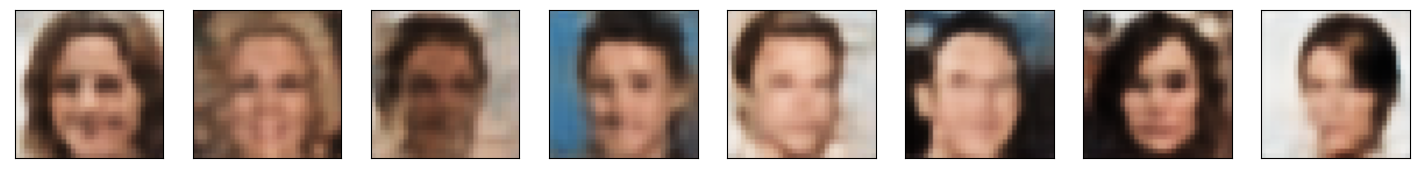

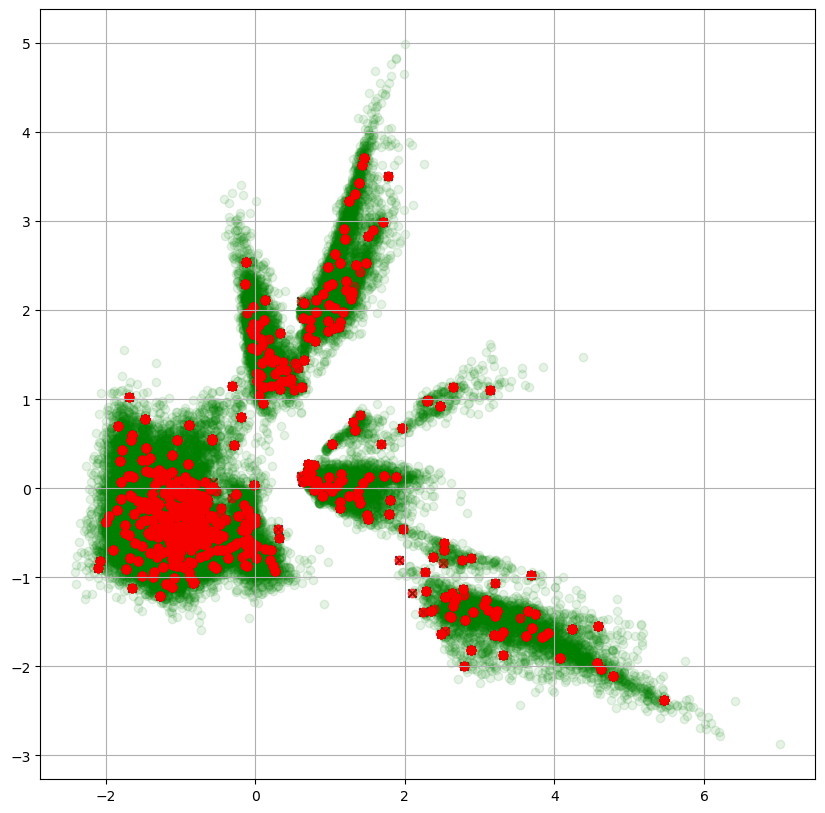

11001
lse_loss 186609.90625
commit_loss 0.004258656408637762
recon_loss 0.008928097784519196
11002
lse_loss 185545.96875
commit_loss 0.004339165054261684
recon_loss 0.0094777662307024
11003
lse_loss 191252.1875
commit_loss 0.004460004158318043
recon_loss 0.009268251247704029
11004
lse_loss 186720.375
commit_loss 0.004307515919208527
recon_loss 0.008846167474985123
11005
lse_loss 185277.359375
commit_loss 0.00432624202221632
recon_loss 0.009219381958246231
11006
lse_loss 187138.03125
commit_loss 0.004412069916725159
recon_loss 0.009738675318658352
11007
lse_loss 193419.59375
commit_loss 0.004378323443233967
recon_loss 0.009028429165482521
11008
lse_loss 186897.5625
commit_loss 0.004254406783729792
recon_loss 0.009486308321356773
11009
lse_loss 187657.125
commit_loss 0.004419112112373114
recon_loss 0.009464597329497337
11010
lse_loss 184994.421875
commit_loss 0.004408787004649639
recon_loss 0.009773816913366318
11011
lse_loss 183645.21875
commit_loss 0.004302916117012501
recon_loss 0.009

11090
lse_loss 185287.5625
commit_loss 0.004284264985471964
recon_loss 0.008890826255083084
11091
lse_loss 191760.390625
commit_loss 0.004261225461959839
recon_loss 0.009956489317119122
11092
lse_loss 183883.546875
commit_loss 0.004265510011464357
recon_loss 0.009146923199295998
11093
lse_loss 191465.03125
commit_loss 0.0043560415506362915
recon_loss 0.010268238373100758
11094
lse_loss 189186.234375
commit_loss 0.004313279874622822
recon_loss 0.009558187797665596
11095
lse_loss 195162.984375
commit_loss 0.004284512251615524
recon_loss 0.009225929155945778
11096
lse_loss 193905.78125
commit_loss 0.0044306679628789425
recon_loss 0.009408267214894295
11097
lse_loss 184202.3125
commit_loss 0.004365301225334406
recon_loss 0.00952868815511465
11098
lse_loss 195654.9375
commit_loss 0.0042364755645394325
recon_loss 0.009300509467720985
11099
lse_loss 186267.1875
commit_loss 0.004402026999741793
recon_loss 0.00956218596547842
11100
lse_loss 179127.21875
commit_loss 0.0042603230103850365
recon_l

11179
lse_loss 172689.8125
commit_loss 0.004129618406295776
recon_loss 0.009052551351487637
11180
lse_loss 181949.4375
commit_loss 0.004147985018789768
recon_loss 0.010053947567939758
11181
lse_loss 172137.625
commit_loss 0.004244794603437185
recon_loss 0.01046895980834961
11182
lse_loss 170032.890625
commit_loss 0.004150247201323509
recon_loss 0.009044195525348186
11183
lse_loss 178807.03125
commit_loss 0.004139776341617107
recon_loss 0.009128262288868427
11184
lse_loss 181154.40625
commit_loss 0.004140638746321201
recon_loss 0.009634098038077354
11185
lse_loss 176690.40625
commit_loss 0.004149865359067917
recon_loss 0.009512921795248985
11186
lse_loss 181919.34375
commit_loss 0.004072834737598896
recon_loss 0.008896391838788986
11187
lse_loss 182195.609375
commit_loss 0.004157977178692818
recon_loss 0.010244060307741165
11188
lse_loss 186243.71875
commit_loss 0.004209973383694887
recon_loss 0.009761804714798927
11189
lse_loss 178253.296875
commit_loss 0.004069497808814049
recon_loss 

11268
lse_loss 166579.671875
commit_loss 0.004026355221867561
recon_loss 0.009481347166001797
11269
lse_loss 176185.46875
commit_loss 0.004117545206099749
recon_loss 0.009895226918160915
11270
lse_loss 176010.15625
commit_loss 0.004215638618916273
recon_loss 0.009830890223383904
11271
lse_loss 178987.921875
commit_loss 0.004159791395068169
recon_loss 0.009853367693722248
11272
lse_loss 173794.625
commit_loss 0.004142576828598976
recon_loss 0.010140814818441868
11273
lse_loss 170605.53125
commit_loss 0.004025792237371206
recon_loss 0.00946594774723053
11274
lse_loss 173778.875
commit_loss 0.004159457050263882
recon_loss 0.01034555584192276
11275
lse_loss 166264.65625
commit_loss 0.004082128405570984
recon_loss 0.009183330461382866
11276
lse_loss 180497.078125
commit_loss 0.004095516167581081
recon_loss 0.00992746651172638
11277
lse_loss 177346.390625
commit_loss 0.004067127127200365
recon_loss 0.010555470362305641
11278
lse_loss 181672.0
commit_loss 0.004134866409003735
recon_loss 0.009

11357
lse_loss 176121.84375
commit_loss 0.004089784808456898
recon_loss 0.009605462662875652
11358
lse_loss 174002.84375
commit_loss 0.004037322476506233
recon_loss 0.009946133010089397
11359
lse_loss 173594.875
commit_loss 0.004098949022591114
recon_loss 0.009539667516946793
11360
lse_loss 171404.0
commit_loss 0.004063026513904333
recon_loss 0.009736397303640842
11361
lse_loss 179287.21875
commit_loss 0.003946959972381592
recon_loss 0.009290343150496483
11362
lse_loss 178763.15625
commit_loss 0.004130123183131218
recon_loss 0.010085608810186386
11363
lse_loss 174117.734375
commit_loss 0.004092440940439701
recon_loss 0.009533999487757683
11364
lse_loss 172809.1875
commit_loss 0.003935384564101696
recon_loss 0.010394633747637272
11365
lse_loss 168542.28125
commit_loss 0.004024786408990622
recon_loss 0.00942864641547203
11366
lse_loss 177361.75
commit_loss 0.004112431779503822
recon_loss 0.010540234856307507
11367
lse_loss 177982.359375
commit_loss 0.0039930883795022964
recon_loss 0.0098

11446
lse_loss 179616.46875
commit_loss 0.003972912672907114
recon_loss 0.009128172881901264
11447
lse_loss 175814.296875
commit_loss 0.00406803609803319
recon_loss 0.00920538417994976
11448
lse_loss 167095.90625
commit_loss 0.003927252721041441
recon_loss 0.009004564955830574
11449
lse_loss 167321.53125
commit_loss 0.00407019630074501
recon_loss 0.009264763444662094
11450
lse_loss 177175.4375
commit_loss 0.004018392413854599
recon_loss 0.00944754108786583
11451
lse_loss 171347.15625
commit_loss 0.004013761878013611
recon_loss 0.009481272660195827
11452
lse_loss 171793.984375
commit_loss 0.004194712731987238
recon_loss 0.009425687603652477
11453
lse_loss 167334.5625
commit_loss 0.003897306974977255
recon_loss 0.009171656332910061
11454
lse_loss 177097.828125
commit_loss 0.003923333249986172
recon_loss 0.009959898889064789
11455
lse_loss 175397.734375
commit_loss 0.003971614874899387
recon_loss 0.009664425626397133
11456
lse_loss 171944.71875
commit_loss 0.003935741726309061
recon_loss 

11535
lse_loss 166402.671875
commit_loss 0.004004975780844688
recon_loss 0.00922685768455267
11536
lse_loss 167350.015625
commit_loss 0.003968989010900259
recon_loss 0.00944578554481268
11537
lse_loss 166686.25
commit_loss 0.0038799094036221504
recon_loss 0.009449699893593788
11538
lse_loss 165792.71875
commit_loss 0.0040029967203736305
recon_loss 0.009581699036061764
11539
lse_loss 167158.796875
commit_loss 0.003955913707613945
recon_loss 0.009658176451921463
11540
lse_loss 166462.140625
commit_loss 0.0039374614134430885
recon_loss 0.009399029426276684
11541
lse_loss 158593.3125
commit_loss 0.003891377244144678
recon_loss 0.00887331459671259
11542
lse_loss 158223.9375
commit_loss 0.00387419736944139
recon_loss 0.008975896053016186
11543
lse_loss 161323.9375
commit_loss 0.003820287762209773
recon_loss 0.009227774105966091
11544
lse_loss 161966.734375
commit_loss 0.0038588857278227806
recon_loss 0.009124215692281723
11545
lse_loss 161690.640625
commit_loss 0.003818041644990444
recon_los

11624
lse_loss 165594.46875
commit_loss 0.0038766751531511545
recon_loss 0.008869045414030552
11625
lse_loss 162243.1875
commit_loss 0.0038325092755258083
recon_loss 0.009265733882784843
11626
lse_loss 159807.6875
commit_loss 0.003852545516565442
recon_loss 0.009358881041407585
11627
lse_loss 160855.03125
commit_loss 0.003934413194656372
recon_loss 0.010039283894002438
11628
lse_loss 158918.65625
commit_loss 0.0038480551447719336
recon_loss 0.009268723428249359
11629
lse_loss 163164.484375
commit_loss 0.003799972590059042
recon_loss 0.009266795590519905
11630
lse_loss 163449.53125
commit_loss 0.003816166426986456
recon_loss 0.008775795809924603
11631
lse_loss 169949.59375
commit_loss 0.00390764232724905
recon_loss 0.00959392637014389
11632
lse_loss 155637.84375
commit_loss 0.003784788306802511
recon_loss 0.009190656244754791
11633
lse_loss 157943.078125
commit_loss 0.003755129873752594
recon_loss 0.00891759805381298
11634
lse_loss 168690.6875
commit_loss 0.00403209775686264
recon_loss 

11713
lse_loss 157607.5625
commit_loss 0.003880591131746769
recon_loss 0.009440174326300621
11714
lse_loss 157701.21875
commit_loss 0.0038482823874801397
recon_loss 0.009051110595464706
11715
lse_loss 159622.875
commit_loss 0.0038350315298885107
recon_loss 0.009266592562198639
11716
lse_loss 166800.90625
commit_loss 0.003886251710355282
recon_loss 0.00995746161788702
11717
lse_loss 163041.25
commit_loss 0.0038581951521337032
recon_loss 0.009217925369739532
11718
lse_loss 163386.3125
commit_loss 0.003923063166439533
recon_loss 0.009410996921360493
11719
lse_loss 164380.328125
commit_loss 0.0037634246982634068
recon_loss 0.009355498477816582
11720
lse_loss 163703.9375
commit_loss 0.0038066410925239325
recon_loss 0.009396311827003956
11721
lse_loss 166952.59375
commit_loss 0.003993087913841009
recon_loss 0.009705043397843838
11722
lse_loss 171903.515625
commit_loss 0.003835671115666628
recon_loss 0.009325247257947922
11723
lse_loss 167242.71875
commit_loss 0.0038381097838282585
recon_loss

In [ ]:
from IPython import display

min_indices = set()
while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 5*1000)
            data = model(data, quant_temp=0, latent_temp=1)
            min_indices.update(list(data['min_indices'].data.cpu().numpy()))

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            ze_pca = pca.transform(data['ze'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            zq_pca = pca.transform(data['zq'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.9, color='black')
            plt.scatter(ze_pca[:, 0], ze_pca[:, 1], marker='o', alpha=0.1, color='green')
            plt.scatter(zq_pca[:, 0], zq_pca[:, 1], marker='o', alpha=0.1, color='red')
            plt.grid()
            plt.show() 
            
            usage = len(min_indices) / hp.n_prior_embeddings
            writer.add_scalar('usage', usage, step)
            min_indices = set()
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')